# COCO object detection

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [23]:
from fastai.vision import *
from fastai.core import *
import json
from collections import defaultdict

## Data

In [87]:
coco = untar_data(URLs.COCO_SAMPLE)

In [101]:
img_dir = coco/'train_sample'
annotations = coco/'annotations'/'train_sample.json'

In [96]:
(coco/'annotations').ls()

[PosixPath('/home/gosia/.fastai/data/coco_sample/annotations/train_sample.json')]

In [102]:
img_list = ImageList.from_folder(img_dir)

In [103]:
img_list

ImageList (21837 items)
Image (3, 487, 600),Image (3, 480, 640),Image (3, 500, 375),Image (3, 425, 640),Image (3, 640, 513)
Path: /home/gosia/.fastai/data/coco_sample/train_sample

In [105]:
#image size
sz = 224

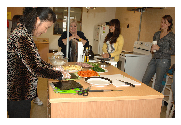

In [106]:
show_image(img_list[3])

In [107]:
with open(annotations) as f:
    train_json = json.load(f)

In [108]:
ncat = len(train_json['categories'])
ncat

6

In [109]:
# count the number of annotations per object
img_ann_counts = defaultdict(lambda: 0)
for ann in train_json['annotations']:
    img_ann_counts[ann['image_id']] += 1

In [110]:
len(img_ann_counts)

21837

In [111]:
images, lbl_bbox = get_annotations(annotations)

In [112]:
lbl_bbox[0], images[0]

([[[0.0, 505.24, 309.25, 553.1],
   [0.0, 470.68, 191.86, 516.61],
   [0.0, 442.51, 119.87, 485.9]],
  ['tv', 'tv', 'tv']],
 '000000318219.jpg')

torch.Size([3, 640, 556])

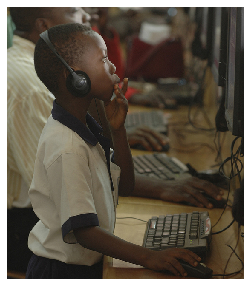

In [113]:
img = open_image(img_dir/images[0])
show_image(img, figsize=(5,5))
img.shape

In [114]:
img2bbox = dict(zip(images, lbl_bbox))
get_y_func = lambda o:img2bbox[o.name]

In [116]:
data = (ObjectItemList.from_folder(coco)
        #Where are the images? -> in coco and its subfolders
        .split_by_rand_pct(valid_pct=0.1, seed=0)                          
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_func(get_y_func)
        #How to find the labels? -> use get_y_func on the file name of the data
        .transform(get_transforms(), size=sz, tfm_y=True)
        #Data augmentation? -> Standard transforms; also transform the label images
        .databunch(bs=16, collate_fn=bb_pad_collate))   
        #Finally we convert to a DataBunch, use a batch size of 16,
        # and we use bb_pad_collate to collate the data into a mini-batch

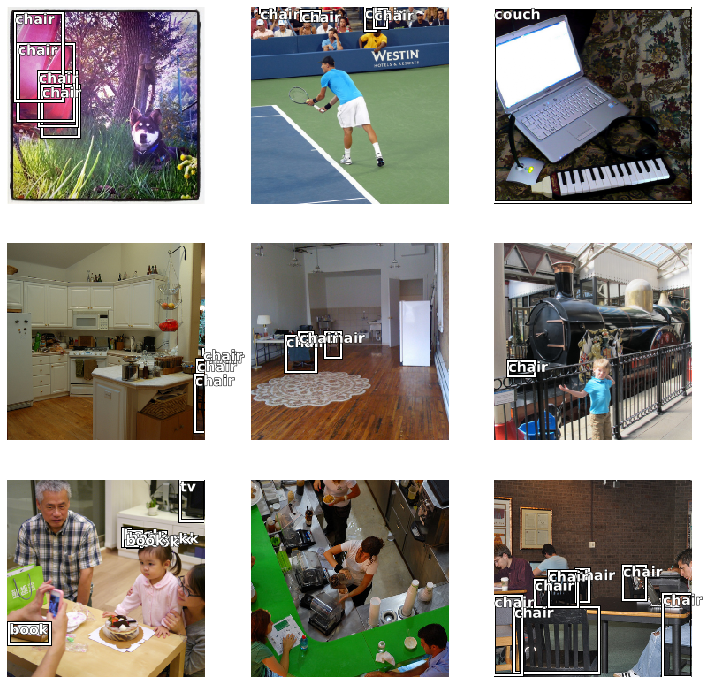

In [117]:
data.show_batch(rows=3, ds_type=DatasetType.Valid, figsize=(10,10))

In [118]:
data

ImageDataBunch;

Train: LabelList (19654 items)
x: ObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: /home/gosia/.fastai/data/coco_sample;

Valid: LabelList (2183 items)
x: ObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: /home/gosia/.fastai/data/coco_sample;

Test: None

In [119]:
data.train_ds.y[0].data[0]

tensor([[ 0.1817, -0.6775,  0.6964, -0.1279],
        [ 0.2357,  0.0674,  0.6065,  0.6069],
        [ 0.6981,  0.3133,  0.9768,  0.9991],
        [ 0.1561, -0.2759,  0.5122,  0.1221],
        [ 0.6063,  0.8373,  0.6979,  1.0000],
        [ 0.1621,  0.3031,  0.2457,  0.3671],
        [ 0.6864,  0.3192,  1.0000,  1.0000],
        [ 0.2509, -0.9978,  1.0000, -0.4996],
        [ 0.2558, -1.0000,  0.9932, -0.4971],
        [ 0.6391,  0.8252,  0.7372,  0.9971]])

## Model

In [120]:
class StdConv(nn.Module):
    def __init__(self, nin, nout, stride=2, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, 3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x): return self.drop(self.bn(F.relu(self.conv(x))))

In [121]:
def flatten_conv(x,k):
    bs,nf,gx,gy = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs,-1,nf//k)

In [122]:
class OutConv(nn.Module):
    def __init__(self, k, nin, bias):
        super().__init__()
        self.k = k
        self.oconv1 = nn.Conv2d(nin, (ncat+1)*k, 3, padding=1)
        self.oconv2 = nn.Conv2d(nin, 4*k, 3, padding=1)
        self.oconv1.bias.data.zero_().add_(bias)
        
    def forward(self, x):
        return [flatten_conv(self.oconv1(x), self.k),
                flatten_conv(self.oconv2(x), self.k)]

In [123]:
class SSD_Head(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(0.25)
        self.sconv0 = StdConv(512,256, stride=1)
#         self.sconv1 = StdConv(256,256)
        self.sconv2 = StdConv(256,256)
        self.out = OutConv(k, 256, bias)
        
    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
#         x = self.sconv1(x)
        x = self.sconv2(x)
        return self.out(x)

In [124]:
head_reg4 = SSD_Head(k=1, bias=-3.)
learn = cnn_learner(data, models.resnet34, custom_head=head_reg4)

In [125]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
ReLU                 [64, 56, 56]         0          False     
___________________________________________________